In [83]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [84]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Análise de Internações

In [85]:
url_database = r"C:\Users\thiag\Downloads\HIST_PAINEL_COVIDBR_04nov2020.csv"
url_output_pdf_BrazilReport = r'C:\Users\thiag\Documents\Python Scripts\Projeto Data Analysis\Projeto COVID Análise\Report_COVID_BR.pdf'
url_output_pdf_SPReport = r'C:\Users\thiag\Documents\Python Scripts\Projeto Data Analysis\Projeto COVID Análise\Report_COVID_SP.pdf'

dfcovid_Internacoes = pd.read_csv("https://raw.githubusercontent.com/seade-R/dados-covid-sp/master/data/plano_sp_leitos_internacoes.csv", sep=";", parse_dates=True)

dfRaw = pd.read_csv(url_database, sep=";" , error_bad_lines=False)


In [86]:
def getDerivativeVector(vec, wind):
    cv = []
    cv.append([np.nan,'inconclusivo'])
    for k in range(wind,len(vec)):
        try:
            value = (vec[k] - vec[k-1])*100/vec[k-1]
        except:
            value = 100
            
        if k <= 7:
            cv.append([value,'inconclusivo'])
        else:
            sum = 0
            for prevs in cv[k-7:k]:
                prev = prevs[0]
                if abs(prev) <= 3:
                    sum = sum + 0
                else:
                    if prev > 0:
                        sum = sum +1
                    else:
                        sum = sum -1
            if(sum >=1):
                cv.append([value,'crescimento'])
            elif (sum <= -1):
                cv.append([value,'queda'])
            else:
                cv.append([value,'estagnado'])
    return cv

In [87]:
def generate_report_int_sp(pdf):
    for mun in listMunicipios:
        listEvolucaoInternacoes = dfcovid_Internacoes[dfcovid_Internacoes.nome_drs==mun][["datahora","internacoes_7v7","internacoes_7d"]]
        listEvolucaoInternacoes.internacoes_7v7 = [x.replace(",",".") for x in listEvolucaoInternacoes.internacoes_7v7.tolist()]

        listEvolucaoInternacoes.internacoes_7v7 = listEvolucaoInternacoes.internacoes_7v7.astype(float)
        listEvolucaoInternacoes.internacoes_7d = listEvolucaoInternacoes.internacoes_7d.astype(float)
        listEvolucaoInternacoes["dev2"] = 0
        listEvolucaoInternacoes["Aval"] = ""
        
        for i in range(0,len(listEvolucaoInternacoes)):
            if(i!=0):
                listEvolucaoInternacoes.iloc[i,3] =  (listEvolucaoInternacoes.iloc[i,1] - listEvolucaoInternacoes.iloc[i-1,1])
            else:
                listEvolucaoInternacoes.iloc[i,3] = 0
        
        for i in range(0,len(listEvolucaoInternacoes)):
            if(listEvolucaoInternacoes.iloc[i,3] >= 3 and listEvolucaoInternacoes.iloc[i,1] >= 3):
                listEvolucaoInternacoes.iloc[i,4] = 0
            elif (listEvolucaoInternacoes.iloc[i,3] >= 3 and listEvolucaoInternacoes.iloc[i,1] < 3):
                listEvolucaoInternacoes.iloc[i,4] = 2
            elif (listEvolucaoInternacoes.iloc[i,3] < 3 and listEvolucaoInternacoes.iloc[i,1] >= 3):
                listEvolucaoInternacoes.iloc[i,4] = 1
            elif (listEvolucaoInternacoes.iloc[i,3] < 3 and listEvolucaoInternacoes.iloc[i,1] < 3):
                listEvolucaoInternacoes.iloc[i,4] = 3
            else:
                listEvolucaoInternacoes.iloc[i,4] = -1
        
        listEvolucaoInternacoes.datahora = pd.to_datetime(listEvolucaoInternacoes.datahora)
        x = listEvolucaoInternacoes.datahora
        y = listEvolucaoInternacoes.internacoes_7v7
        y2 = listEvolucaoInternacoes.internacoes_7d
        y3 = listEvolucaoInternacoes.dev2
        z = [0 for data in x]

        fig, ax1 = plt.subplots(figsize=(20,6))
        plt.xticks(rotation=45)
        plt.title("Internações Municipio " + mun)
        color = 'tab:red'
        ax1.set_xlabel('Datas')
        ax1.set_ylabel('Taxa de Crescimento comparativo Semanal %', color=color)
        ax1.plot(x, y, color=color)
        ax1.plot(x, z,'--', color=color)
        #ax1.plot(x, y3,'--', color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),
                      listEvolucaoInternacoes['Aval'].values[np.newaxis],
                      cmap='RdYlGn', alpha=0.3)
        
        ax1.xaxis_date()
    
        import matplotlib.dates as mdates
        myFmt = mdates.DateFormatter('%m-%d')
        ax1.xaxis.set_major_formatter(myFmt)


        locator = mdates.AutoDateLocator(minticks=3, maxticks=15)
        ax1.xaxis.set_major_locator(locator)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Qtd de Novas Internações Últimos 7 dias', color=color)  # we already handled the x-label with ax1
        ax2.plot(x, y2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
        pdf.savefig(fig)
        plt.close()

In [88]:
def get_daily_death_and_cases_axis(dfRaw, ax, estado, janela = 7, flag_growth = 'no'):
    dfBrasil = dfRaw[(dfRaw.estado == estado)  & ~(dfRaw.municipio.isna())]
    
    if(len(dfBrasil)==0):
        dfBrasil = dfRaw[(dfRaw.regiao == estado)  & ~(dfRaw.municipio.isna())]
        if(len(dfBrasil)==0):
            return

    dfBrasil = dfBrasil.groupby("data").agg(Recuperadosnovos=('Recuperadosnovos', 'sum'),
                                    casosAcumulado = ('casosAcumulado', 'sum'),
                                        casosNovos = ('casosNovos','sum'),
                                        obitosNovos = ('obitosNovos','sum')
                                        
                                   ).reset_index()
    dfBrasil = dfBrasil.fillna(0)
    
    dfBrasil["recuperadosPorDia"] = 0
    for i in range(0,len(dfBrasil)):
                if(i!=0):
                    dfBrasil.iloc[i,len(dfBrasil.columns)-1] =  (dfBrasil.iloc[i,1] - dfBrasil.iloc[i-1,1])
                else:
                    dfBrasil.iloc[i,len(dfBrasil.columns)-1] = 0

    dfBrasil = dfBrasil.fillna(0)
    
    dfBrasil["new index"] = dfBrasil.Recuperadosnovos/dfBrasil.casosAcumulado
    dfBrasil = dfBrasil.fillna(0)
    
    wind = janela
    plt.rcParams.update({'font.size': 12})
    dfBrasil.data = pd.to_datetime(dfBrasil.data)
    x = dfBrasil.data
    y2 = dfBrasil.casosNovos.rolling(window=wind).mean()
    y3 = dfBrasil.obitosNovos.rolling(window=wind).mean()
    
    color = 'tab:red'
    ax.set_xlabel('Datas')
    ax.set_title('Estado: ' + estado)
    ax.set_ylabel('Qtd de Novos Casos Diários', color=color)
    l1 = ax.plot(x, y2, color='r', label='Qtd de Novos Casos - Média Móvel (Dias): ' + str(wind))
    
    if (flag_growth != 'no'):
        
        if(flag_growth == 'last'):
            firstorderiv = getDerivativeVector(y3, 1)
            if(firstorderiv[-3][1]=='crescimento'):
                ax.axvspan(x[0], x[len(x)-1] , alpha=0.5, color='red')
            elif (firstorderiv[-3][1]=='queda'):
                ax.axvspan(x[0], x[len(x)-1] , alpha=0.5, color='green')
            elif (firstorderiv[-3][1]=='estagnado'):
                ax.axvspan(x[0], x[len(x)-1], alpha=0.5, color='yellow')
            else:
                ax.axvspan(x[0], x[len(x)-1] , alpha=0.5, color='gray')
            
        else:
            if(flag_growth == 'casos'):
                firstorderiv = getDerivativeVector(y2, 1)
            else:
                firstorderiv = getDerivativeVector(y3, 1)

            for index,xd in enumerate(x):
                if(index<len(x)-1):
                    if(firstorderiv[index][1]=='crescimento'):
                        ax.axvspan(xd, x[index+1] , alpha=0.5, color='red')
                    elif (firstorderiv[index][1]=='queda'):
                        ax.axvspan(xd, x[index+1] , alpha=0.5, color='green')
                    elif (firstorderiv[index][1]=='estagnado'):
                        ax.axvspan(xd, x[index+1] , alpha=0.5, color='yellow')
                    else:
                        ax.axvspan(xd, x[index+1] , alpha=0.5, color='gray')
    
    ax.tick_params(axis='y', labelcolor=color)
    
    ax.xaxis_date()
    
    import matplotlib.dates as mdates
    myFmt = mdates.DateFormatter('%m-%d')
    ax.xaxis.set_major_formatter(myFmt)
    
    
    locator = mdates.AutoDateLocator(minticks=3, maxticks=15)
    ax.xaxis.set_major_locator(locator)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'k'
    ax2.set_ylabel('Qtd de óbitos novos', color='k')  # we already handled the x-label with ax1
    l2 = ax2.plot(x, y3, color='k', label='Qtd de Novos óbitos - Média Móvel (Dias): ' + str(wind))
    ax2.tick_params(axis='y', labelcolor=color)
    
    # added these three lines
    lns = l1+l2
    labs = [l.get_label() for l in lns]
    #fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 1.05))
    return labs
    #ax.legend(lns, labs, loc=0)

In [89]:
def get_panel_by_region(pdf):
    #Fornece os gráficos das Macro-Regiões com relação a média móvel semanal dos novos casos diários e óbitos diários

    vetor_controle = [[[3,3],['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO'],'Norte'],
                     [[3,3],['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'],'Nordeste'],
                     [[2,2],['MS', 'MT', 'GO', 'DF'],'Centro-Oeste'],
                     [[2,2],['PR', 'SC', 'RS'],'Sul'],
                     [[2,2],['MG', 'ES', 'RJ', 'SP'],'Sudeste']]

    for v in vetor_controle:
        dim = v[0]
        est = v[1]
        plt.rcParams['savefig.facecolor'] = "0.8"
        plt.rcParams.update({'font.size': 9})

        plt.close('all')
        fig = plt.figure()

        fig.set_figheight(18)
        fig.set_figwidth(15)

        axt = plt.subplot2grid((dim[1]+1, dim[0]), (0, 0), colspan=dim[0])
        plt.setp(axt.get_xticklabels(), rotation=45)
        labels = get_daily_death_and_cases_axis(dfRaw, axt, v[2], janela = 7, flag_growth = 'obitos')

        k = 0
        for index in range(1,dim[1]+1):
            for i in range(0,dim[0]):
                if(k<len(est)):
                    axt = plt.subplot2grid((dim[1]+1, dim[0]), (index, i))
                    plt.setp(axt.get_xticklabels(), rotation=45)
                    lbs = get_daily_death_and_cases_axis(dfRaw, axt, est[k], janela = 7, flag_growth = 'obitos')

                k = k + 1

        fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 1.05))

        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.show()
        pdf.savefig(fig)

In [90]:
def full_panel_country(pdf):
#Fornece uma grade de 27 estados
    dim = [3,9]
    est = ['RO',
     'AC',
     'AM',
     'RR',
     'PA',
     'AP',
     'TO',
     'MA',
     'PI',
     'CE',
     'RN',
     'PB',
     'PE',
     'AL',
     'SE',
     'BA',
     'MG',
     'ES',
     'RJ',
     'SP',
     'PR',
     'SC',
     'RS',
     'MS',
     'MT',
     'GO',
     'DF']
    plt.rcParams['savefig.facecolor'] = "0.8"
    plt.rcParams.update({'font.size': 9})

    plt.close('all')
    fig = plt.figure()

    fig.set_figheight(30)
    fig.set_figwidth(15)

    k = 0
    for index in range(0,dim[1]):
        for i in range(0,dim[0]):
            if(k<len(est)):
                axt = plt.subplot2grid((dim[1], dim[0]), (index, i))
                plt.setp(axt.get_xticklabels(), rotation=45)
                lbs = get_daily_death_and_cases_axis(dfRaw, axt, est[k], janela = 7, flag_growth = 'last')

            if k==0:
                labels = lbs

            k = k + 1

    fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 1.05))

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()
    pdf.savefig(fig)

In [91]:
def get_evolution_recovery(dfRaw, pdf, janela = 7):
    
    dfBrasil = dfRaw[dfRaw.regiao == "Brasil"]

    dfBrasil = dfBrasil.groupby("data").agg(Recuperadosnovos=('Recuperadosnovos', 'sum'),
                                    casosAcumulado = ('casosAcumulado', 'sum'),
                                        casosNovos = ('casosNovos','sum'),
                                        obitosNovos = ('obitosNovos','sum')

                                   ).reset_index()
    dfBrasil = dfBrasil.fillna(0)

    dfBrasil["recuperadosPorDia"] = 0
    for i in range(0,len(dfBrasil)):
                if(i!=0):
                    if((dfBrasil.iloc[i,1] - dfBrasil.iloc[i-1,1])>=0):
                        dfBrasil.iloc[i,len(dfBrasil.columns)-1] = (dfBrasil.iloc[i,1] - dfBrasil.iloc[i-1,1])
                    else:
                        if(dfBrasil.iloc[i,1] < 1000000):
                            dfBrasil.iloc[i,len(dfBrasil.columns)-1] = (dfBrasil.iloc[i,2]  - dfBrasil.iloc[i,1]) - dfBrasil.iloc[i-1,1]
                            dfBrasil.iloc[i,1] = (dfBrasil.iloc[i,2]  - dfBrasil.iloc[i,1])
                        else:
                            dfBrasil.iloc[i,len(dfBrasil.columns)-1] = (dfBrasil.iloc[i,1] - dfBrasil.iloc[i-1,1])
                else:
                    dfBrasil.iloc[i,len(dfBrasil.columns)-1] = 0

    dfBrasil = dfBrasil.fillna(0)

    dfBrasil["new index"] = dfBrasil.Recuperadosnovos/dfBrasil.casosAcumulado
    dfBrasil = dfBrasil.fillna(0)

    wind = janela
    plt.rcParams.update({'font.size': 12})
    dfBrasil.data = pd.to_datetime(dfBrasil.data)
    x = dfBrasil.data
    y = dfBrasil["recuperadosPorDia"].rolling(window=wind).mean()
    y2 = dfBrasil.casosNovos.rolling(window=wind).mean()
    y3 = dfBrasil.obitosNovos.rolling(window=wind).mean()
    z = (y2-y).rolling(window=wind).mean()

    fig, ax1 = plt.subplots(figsize=(20,10))
    plt.xticks(rotation=45)
    plt.title("Evolução nas Taxas de Recuperação e Novos Casos")
    color = 'tab:red'
    ax1.set_xlabel('Datas')
    ax1.set_ylabel('Qtd de Novos Casos Diários', color=color)
    l1 = ax1.plot(x, y, color='g', label='Qtd de Novas Recuperações - Média Móvel (Dias): ' + str(wind))
    l3 = ax1.plot(x, y2, color='r', label='Qtd de Novos Casos - Média Móvel (Dias): ' + str(wind))
    l4 = ax1.plot(x, z, color='b', label='Diferença entre Novos Casos e Novas Recuperações - Média Móvel (Dias): ' + str(wind))
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax1.xaxis_date()
    
    import matplotlib.dates as mdates
    myFmt = mdates.DateFormatter('%m-%d')
    ax1.xaxis.set_major_formatter(myFmt)
    
    
    locator = mdates.AutoDateLocator(minticks=3, maxticks=15)
    ax1.xaxis.set_major_locator(locator)


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    

    color = 'k'
    ax2.set_ylabel('Qtd de óbitos novos', color='k')  # we already handled the x-label with ax1
    l2 = ax2.plot(x, y3, color='k', label='Qtd de Novos óbitos - Média Móvel (Dias): ' + str(wind))
    ax2.tick_params(axis='y', labelcolor=color)

    # added these three lines
    lns = l1+l3+l4+l2
    labs = [l.get_label() for l in lns]
    fig.legend(labs, loc='upper center', bbox_to_anchor=(0.23, 0.95))

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    pdf.savefig(fig)
    plt.close()  


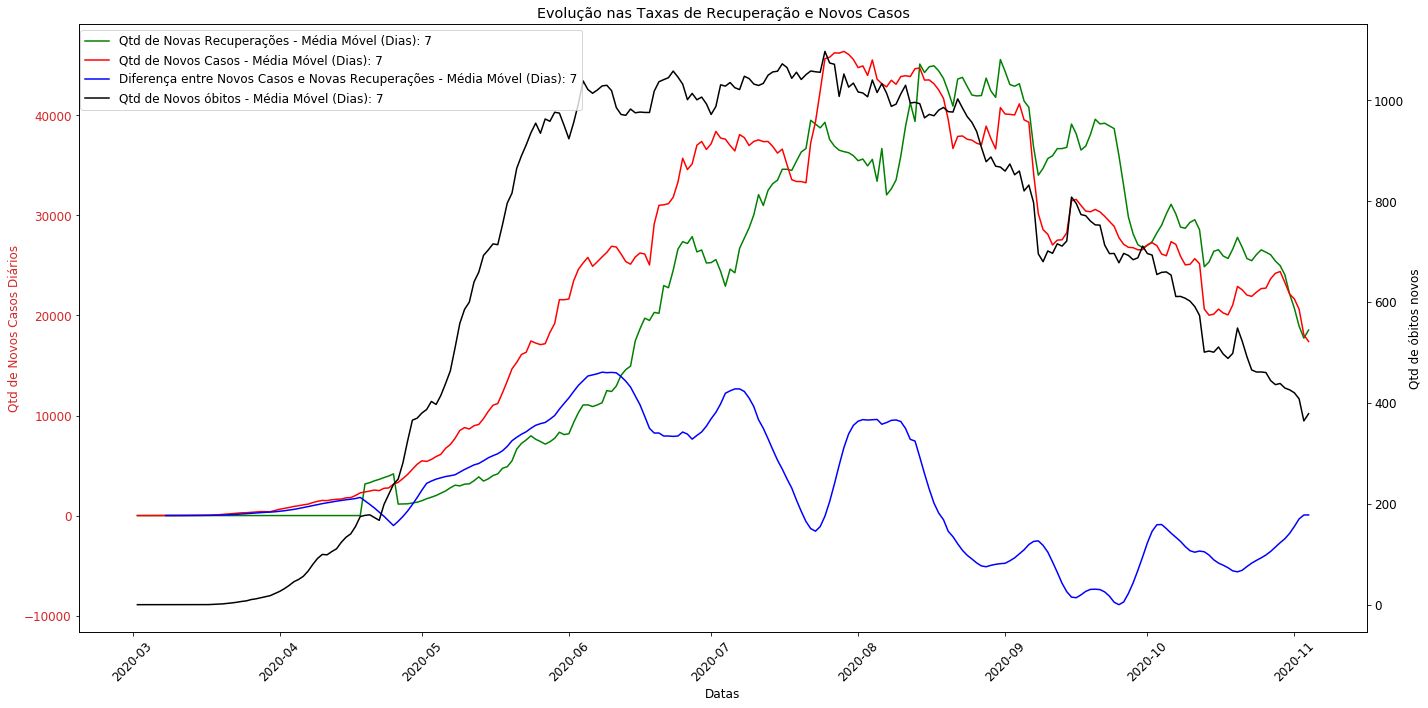

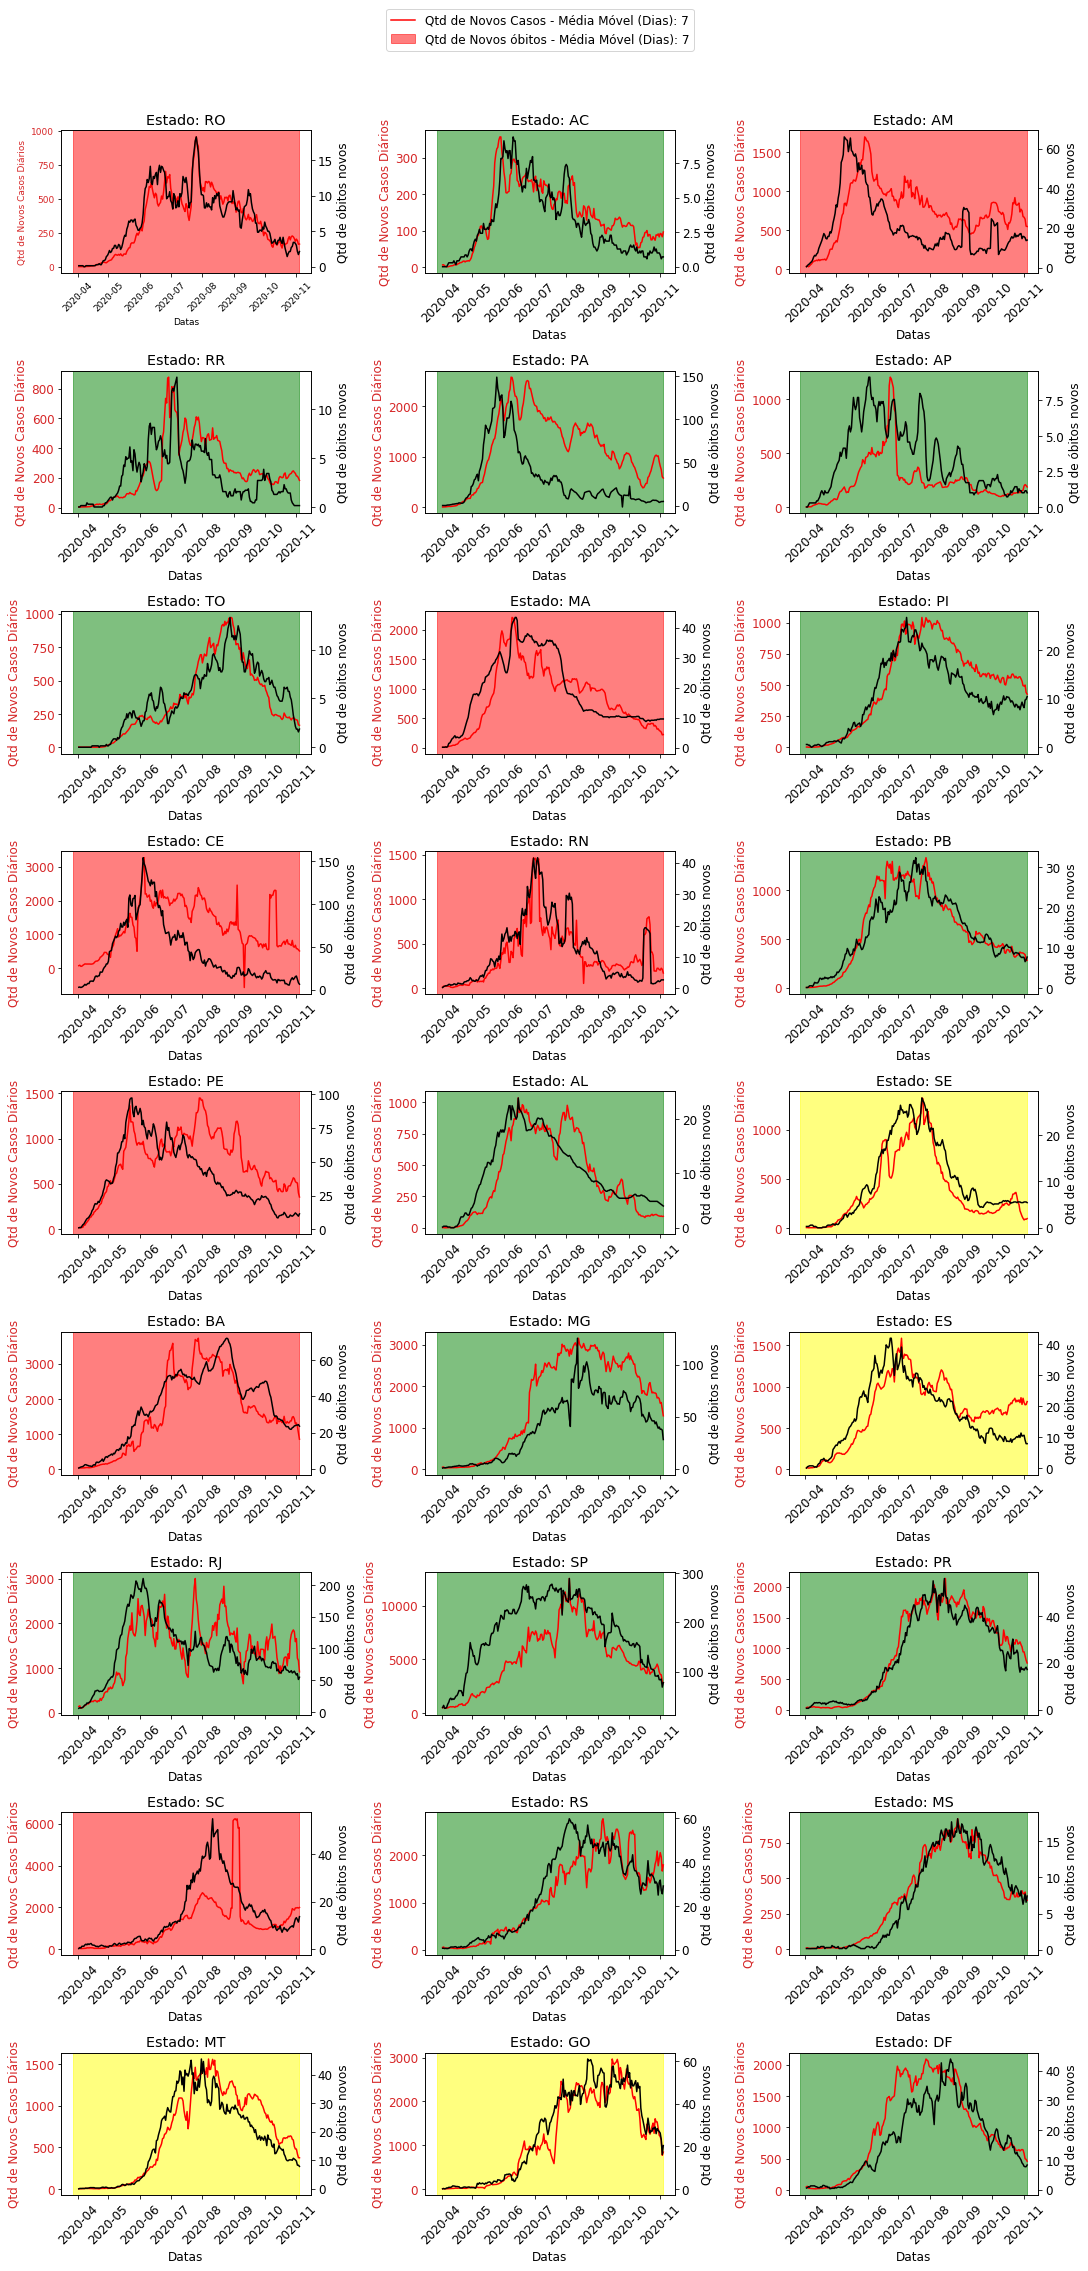

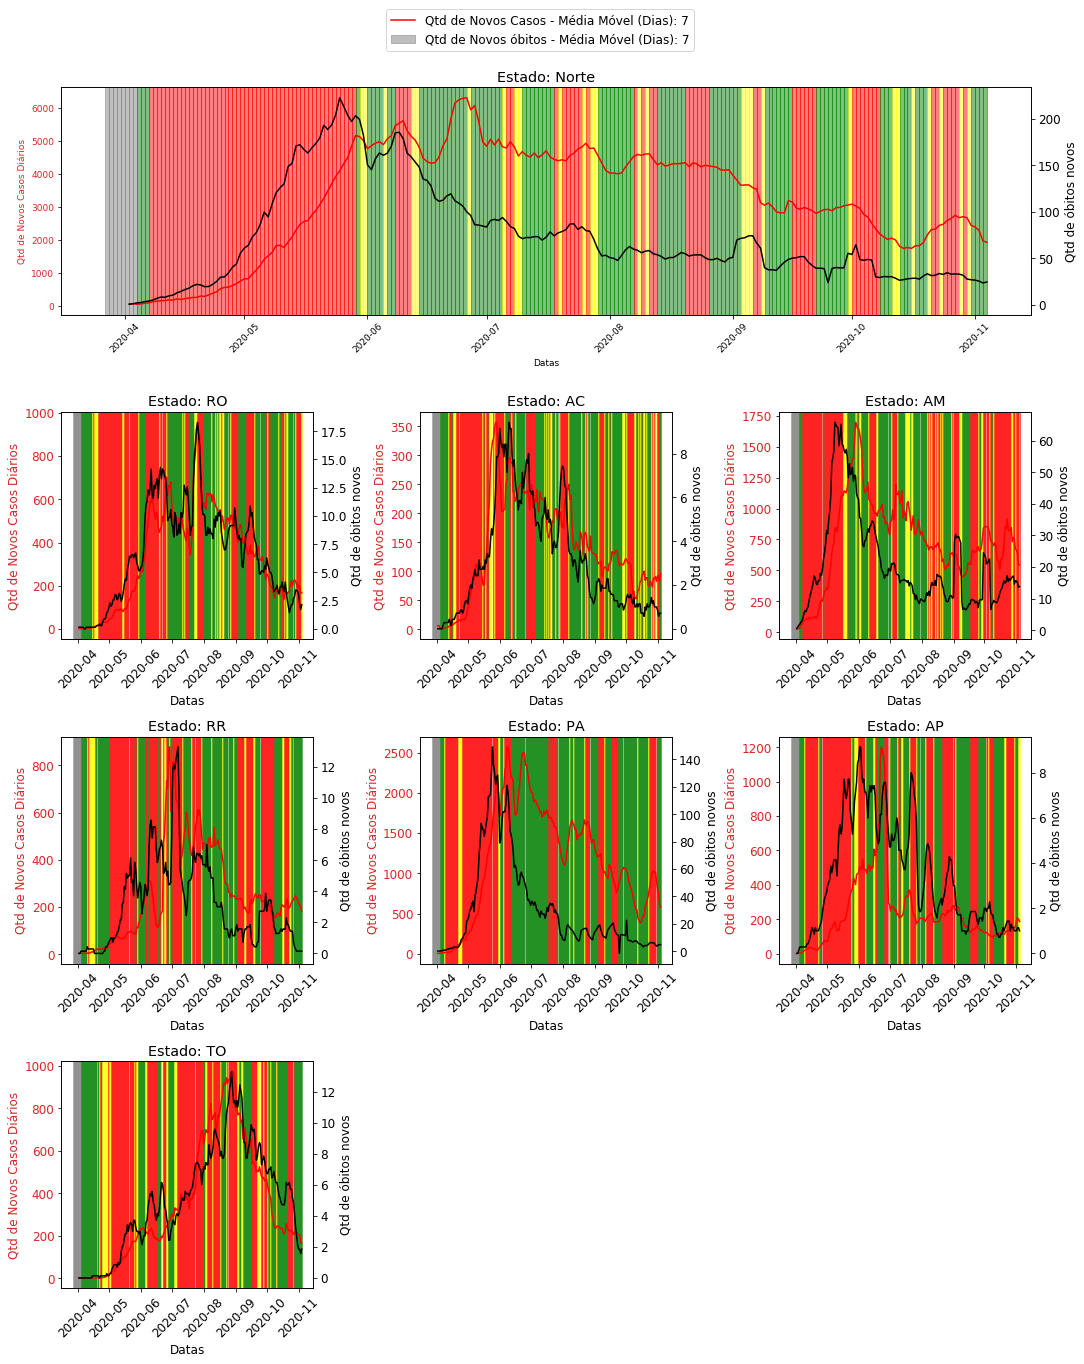

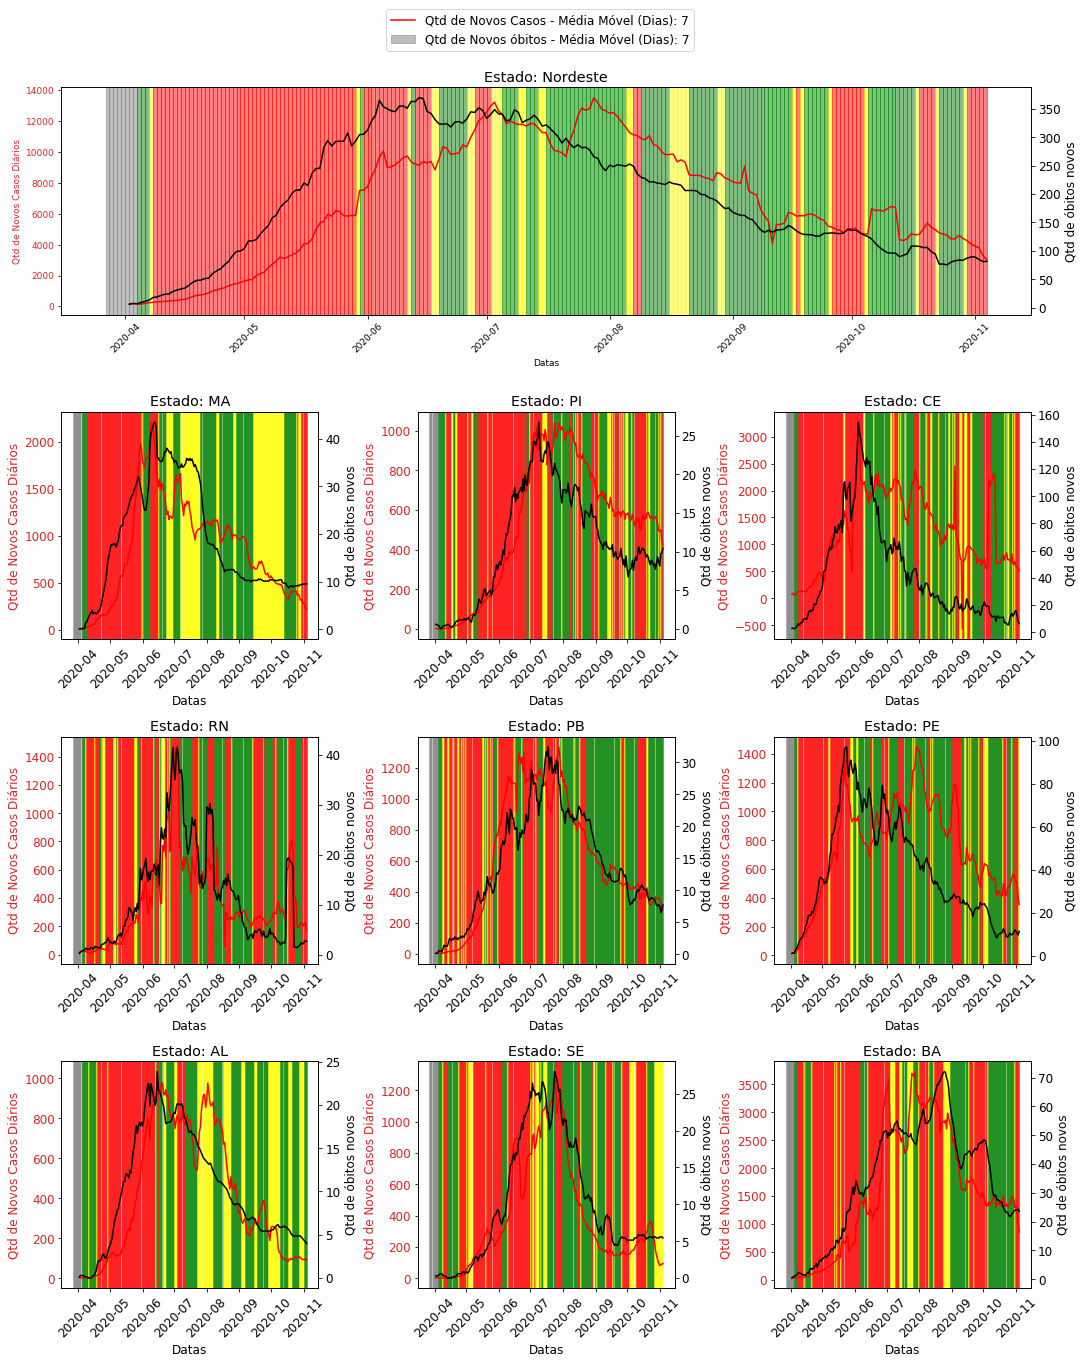

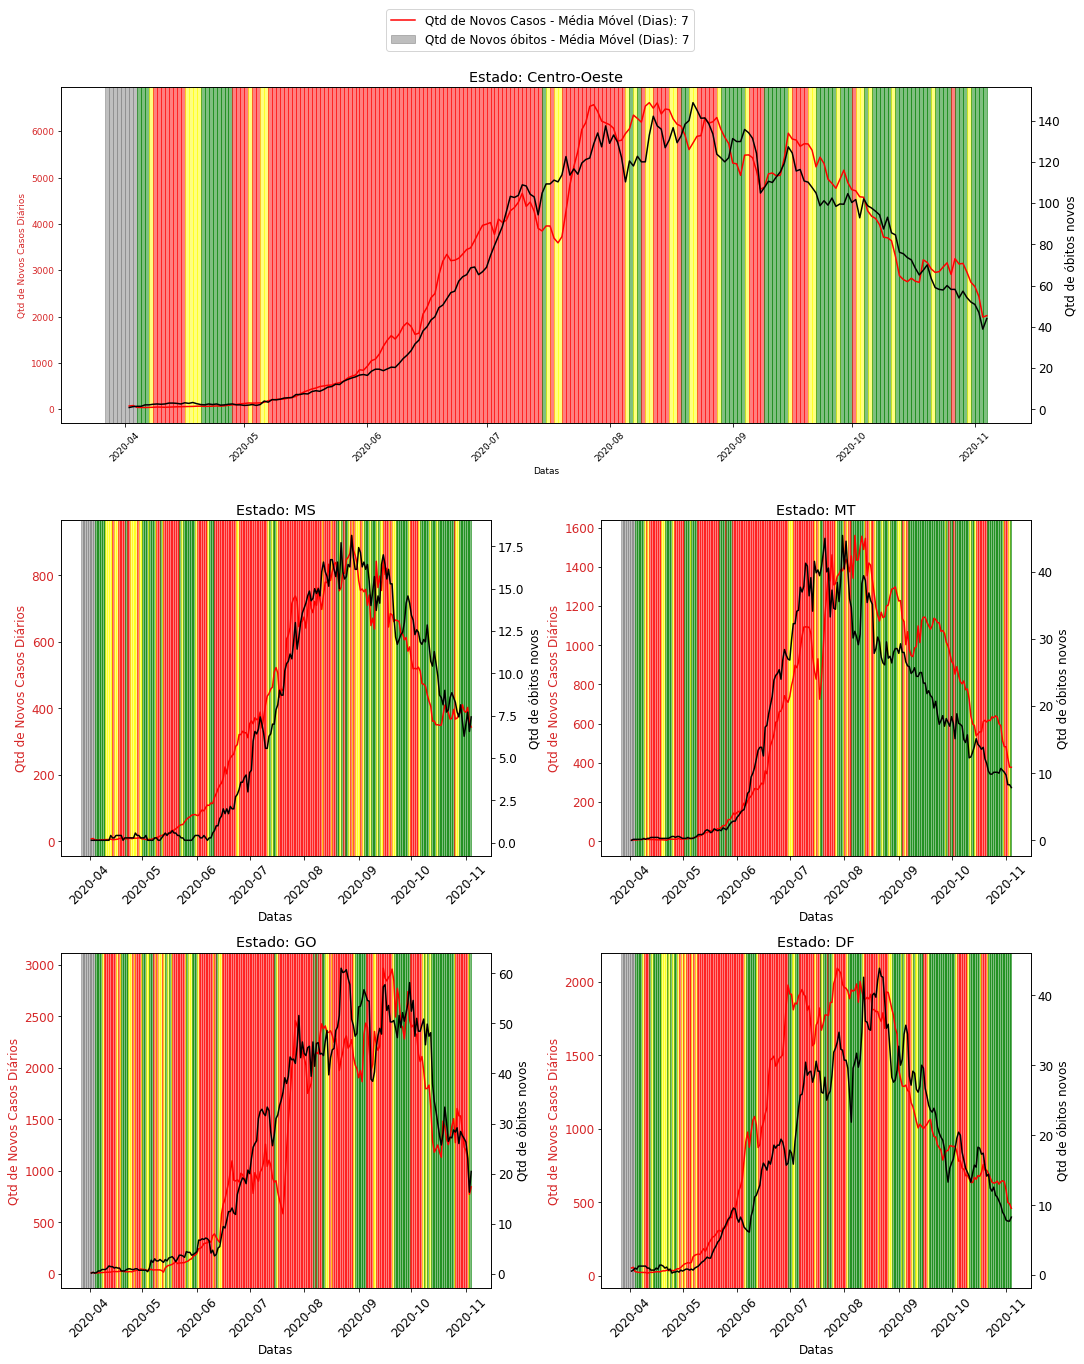

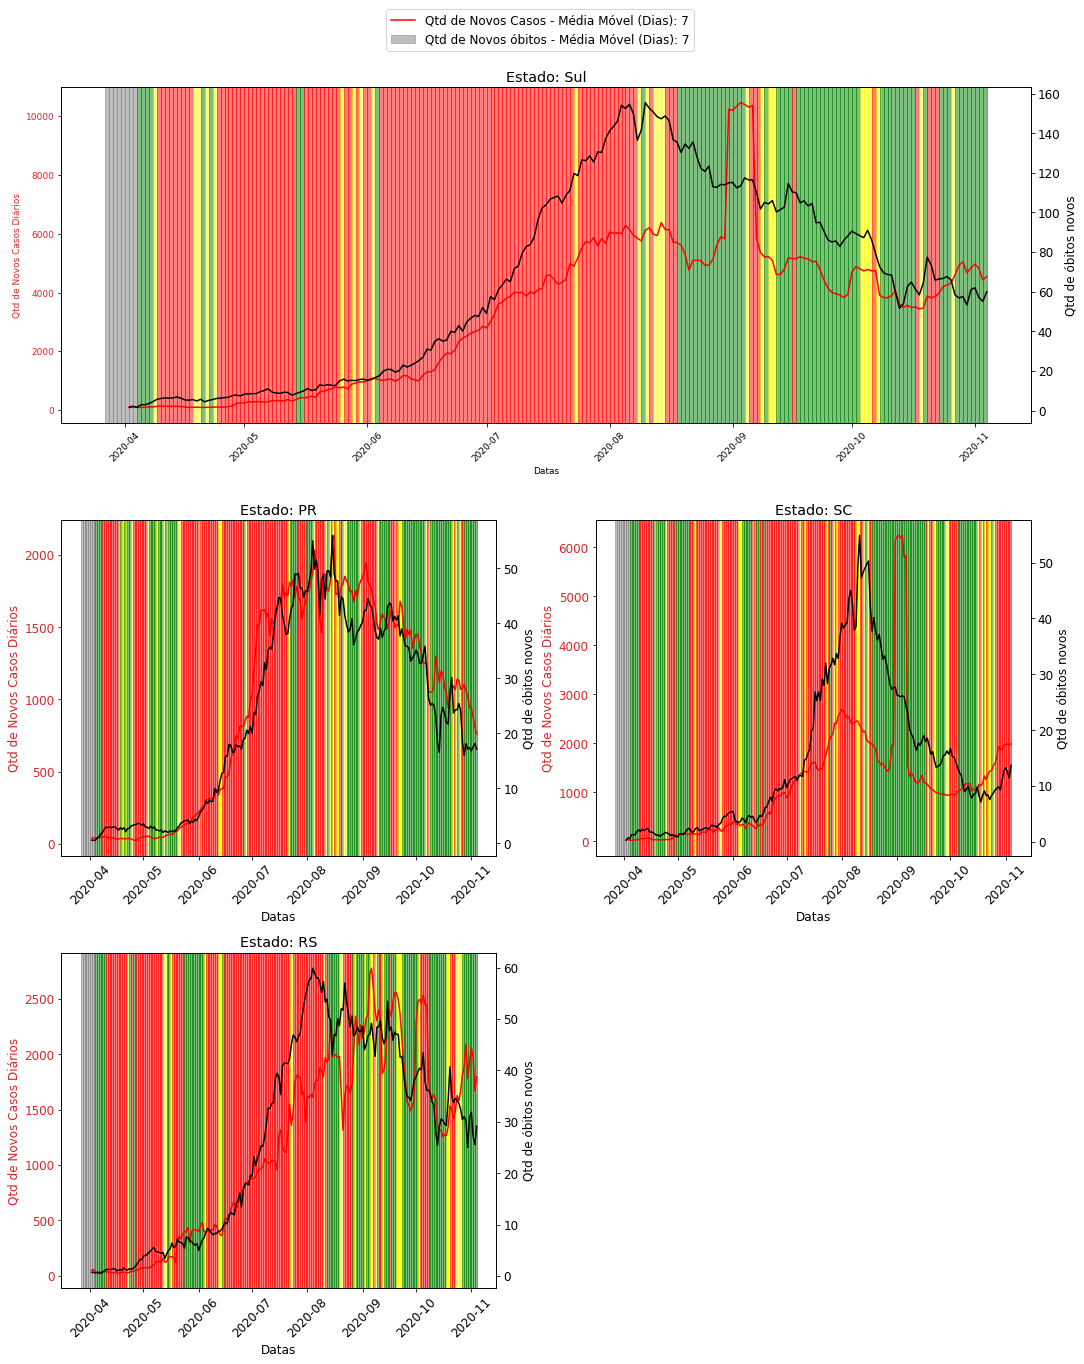

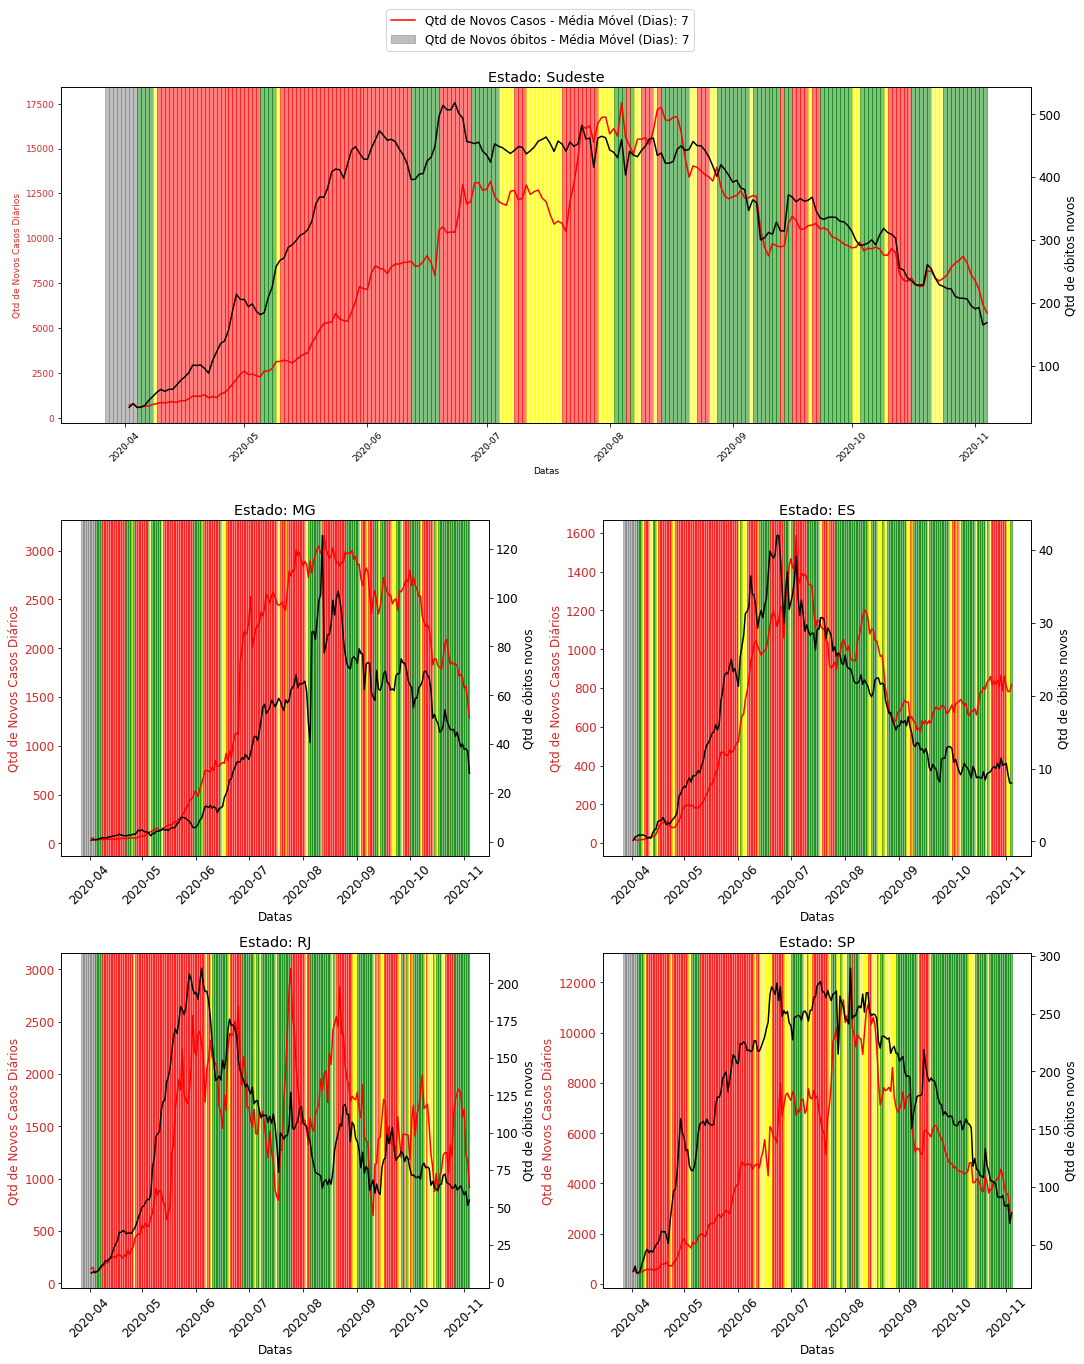

In [92]:
with PdfPages(url_output_pdf_BrazilReport) as pdf:
    
    a = get_evolution_recovery(dfRaw, pdf, janela = 7)
    full_panel_country(pdf)
    get_panel_by_region(pdf)
        
    d = pdf.infodict()
    d['Title'] = 'Análise de Evolução COVID - Brasil Visão Nacional'
    d['Author'] = 'Thiago Villani'
    d['Subject'] = 'Fonte: Relatórios diários em CSV do Ministério da Saúde'

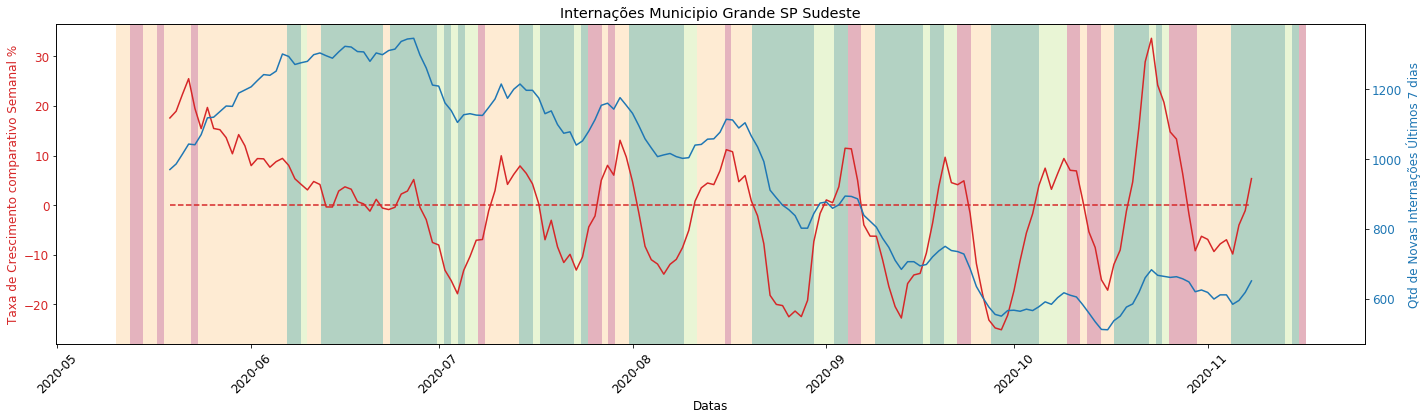

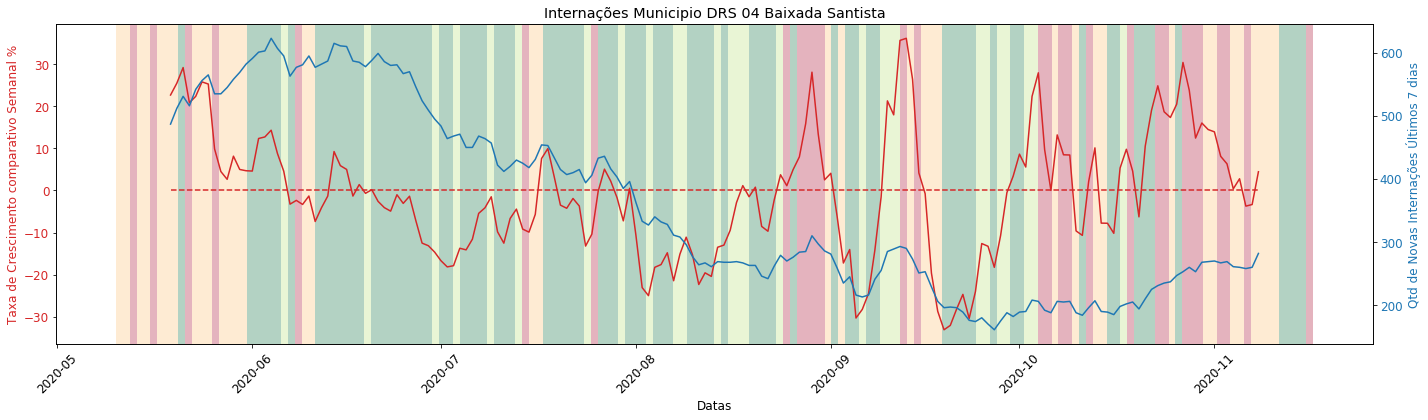

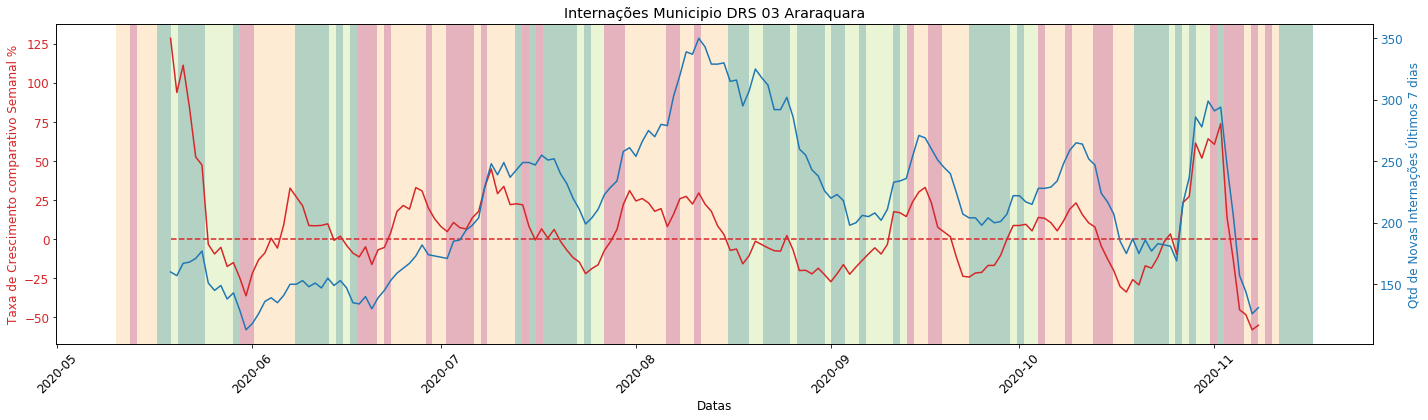

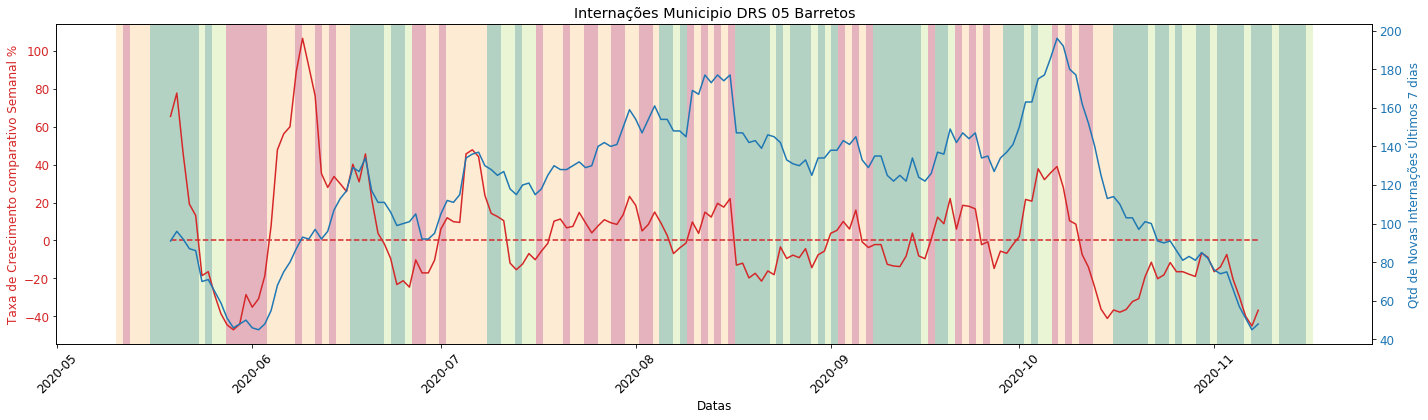

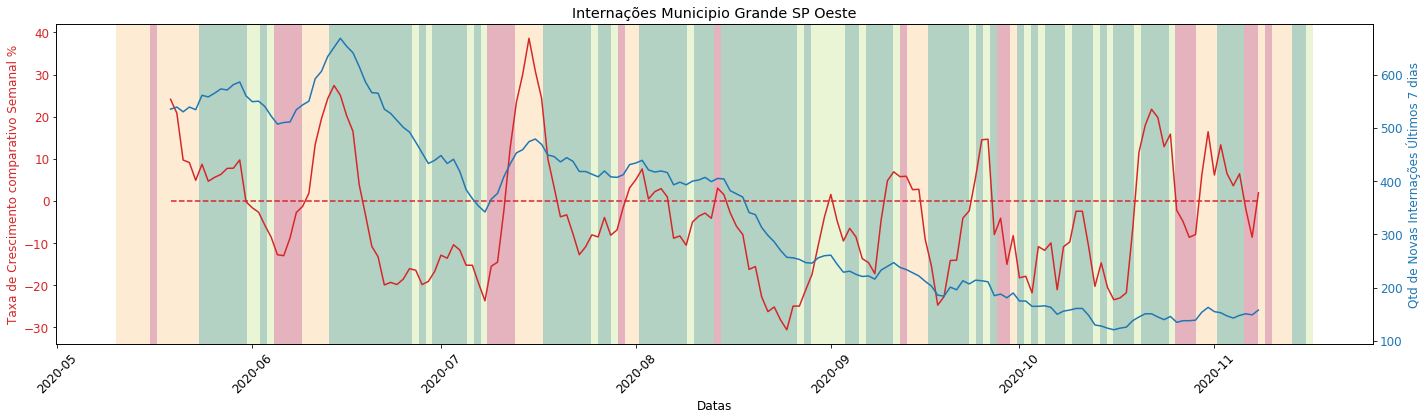

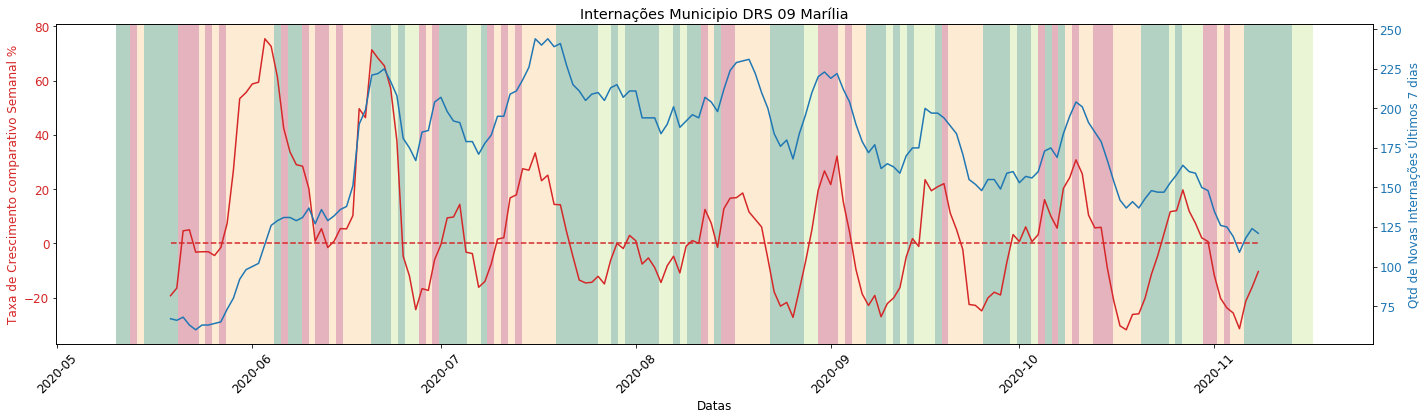

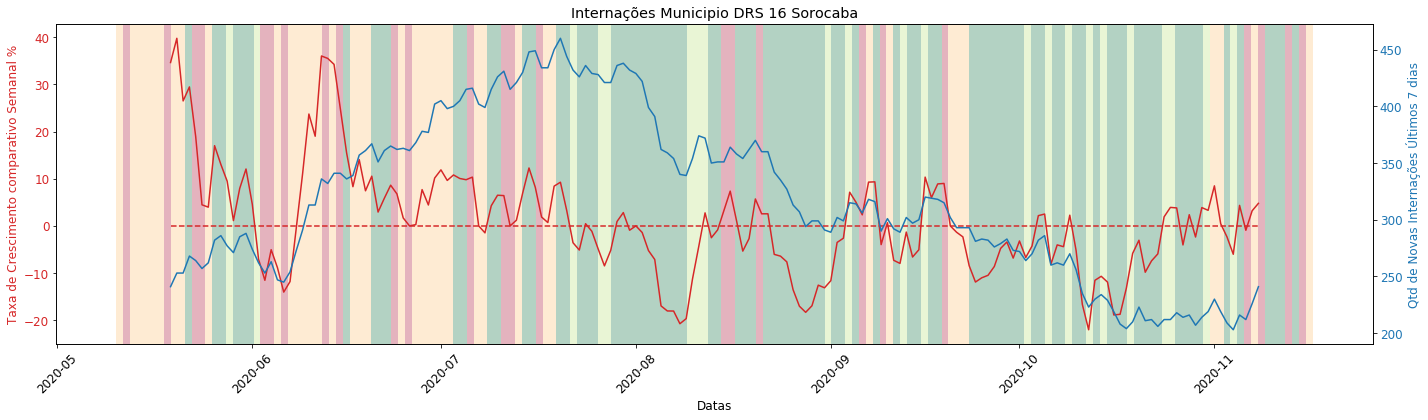

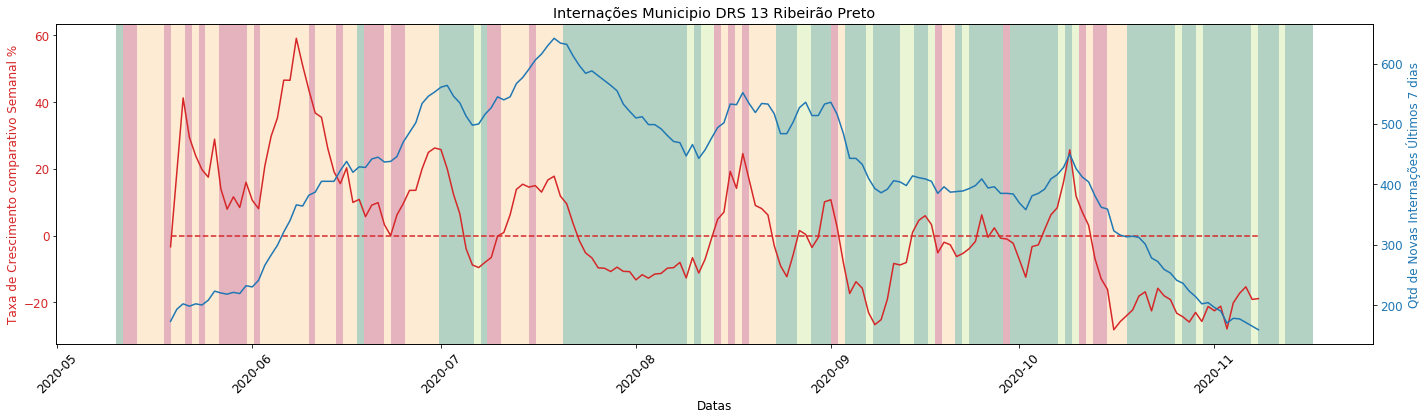

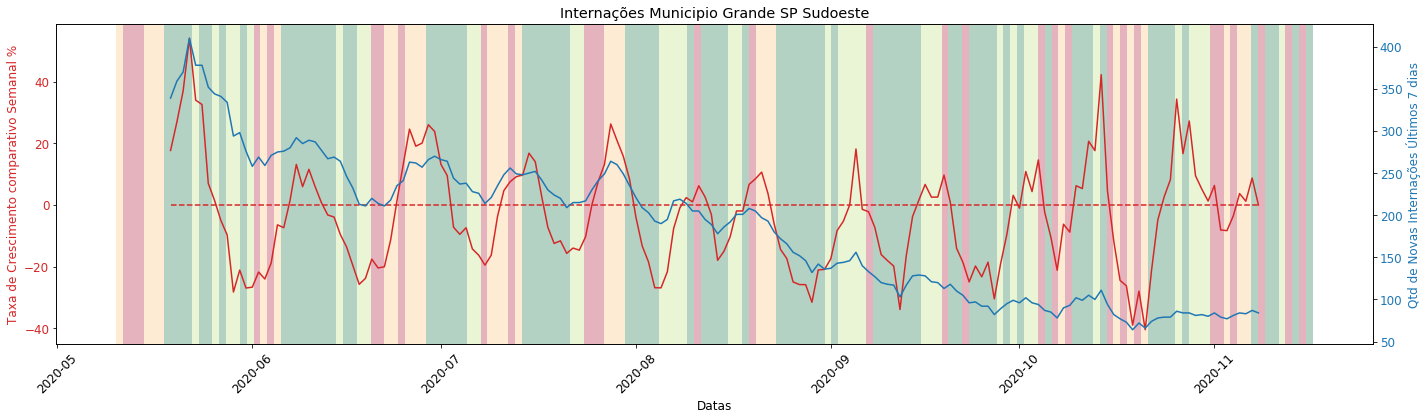

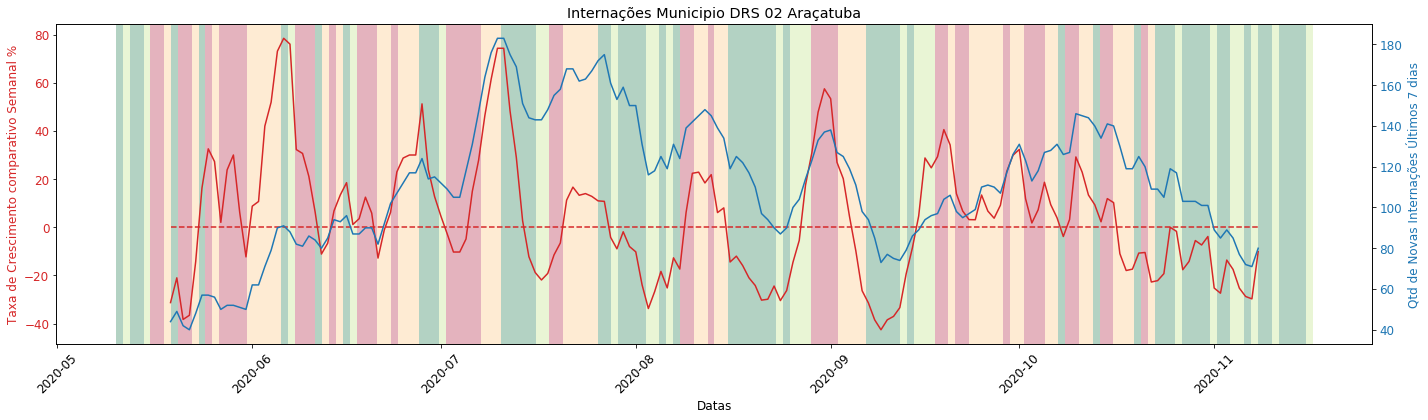

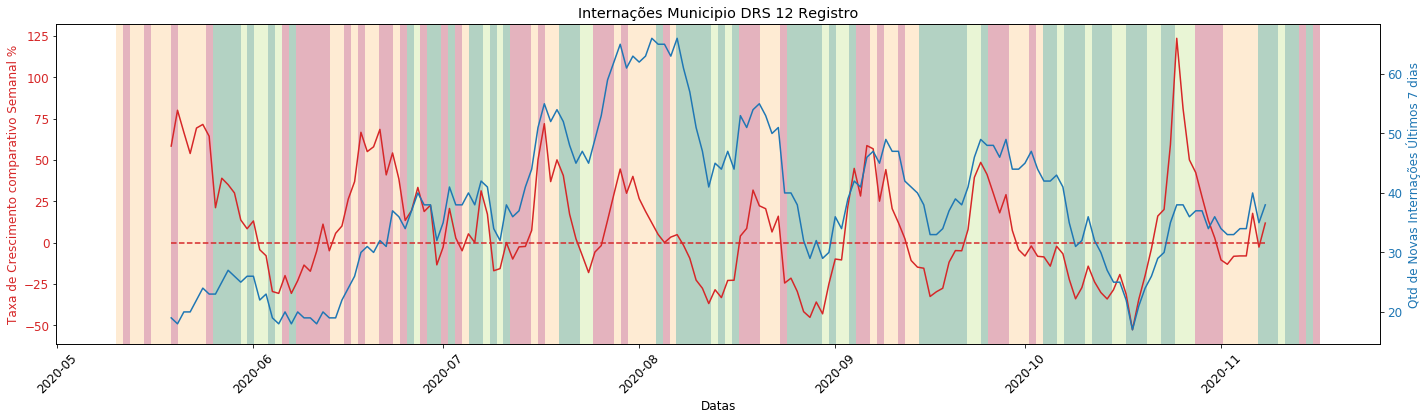

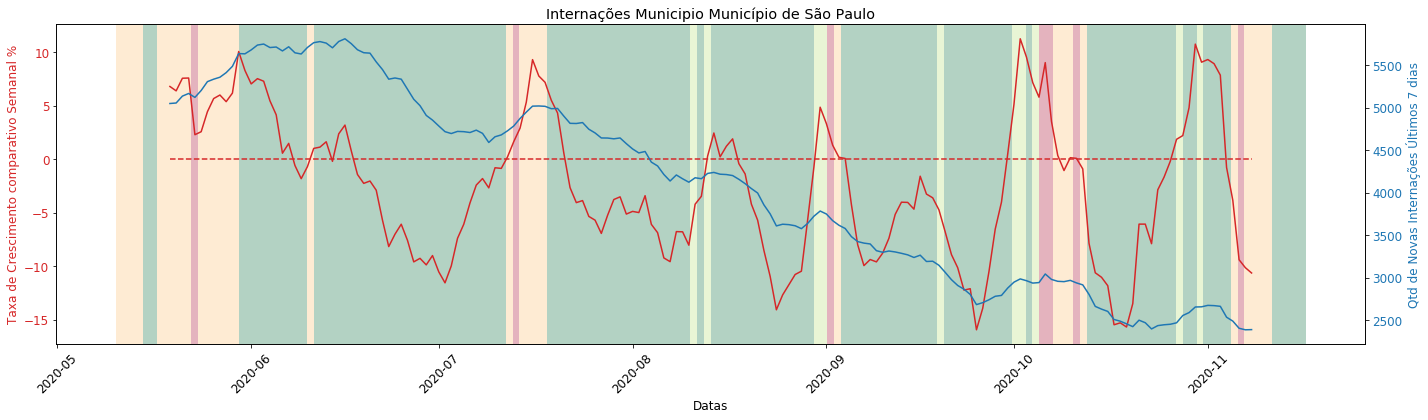

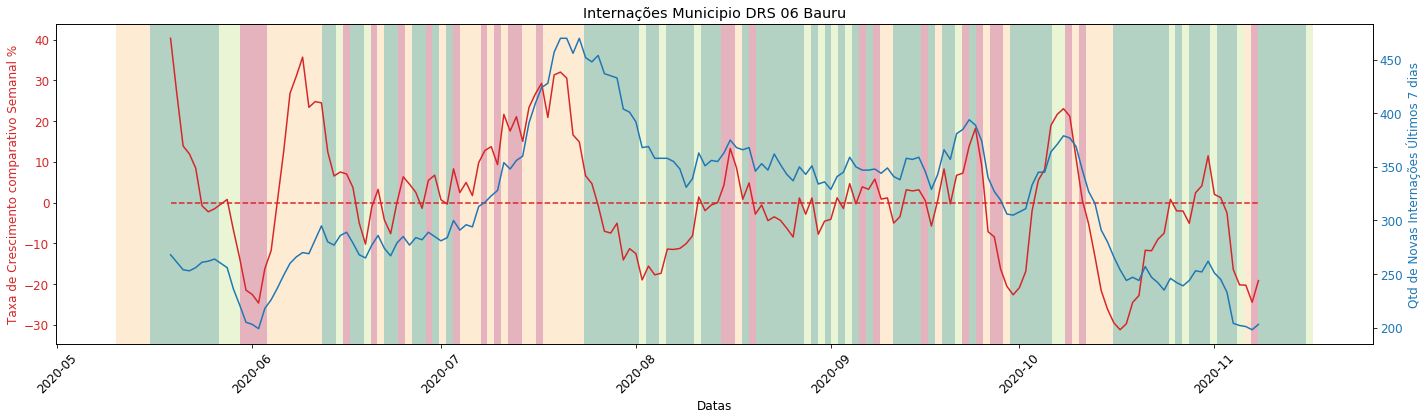

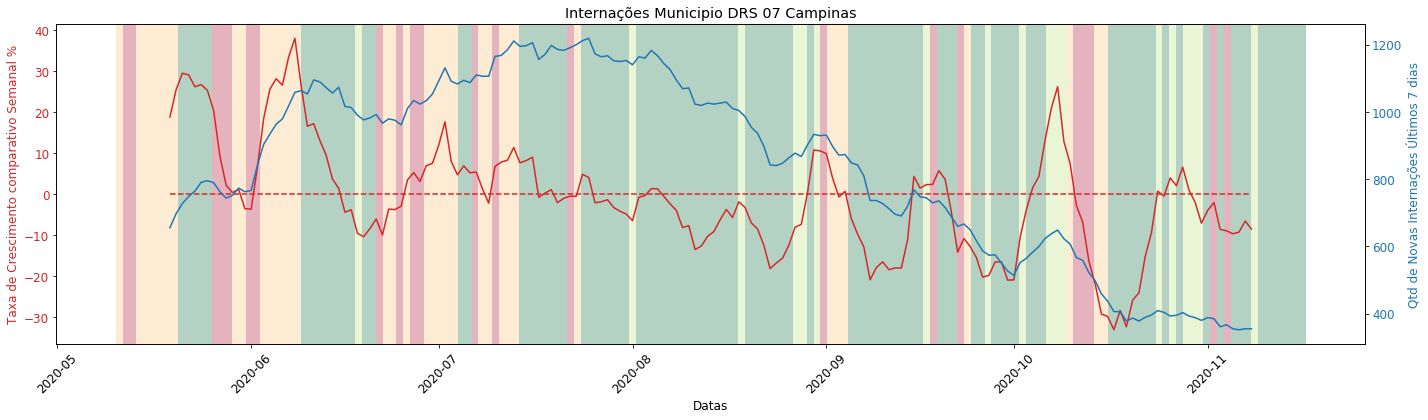

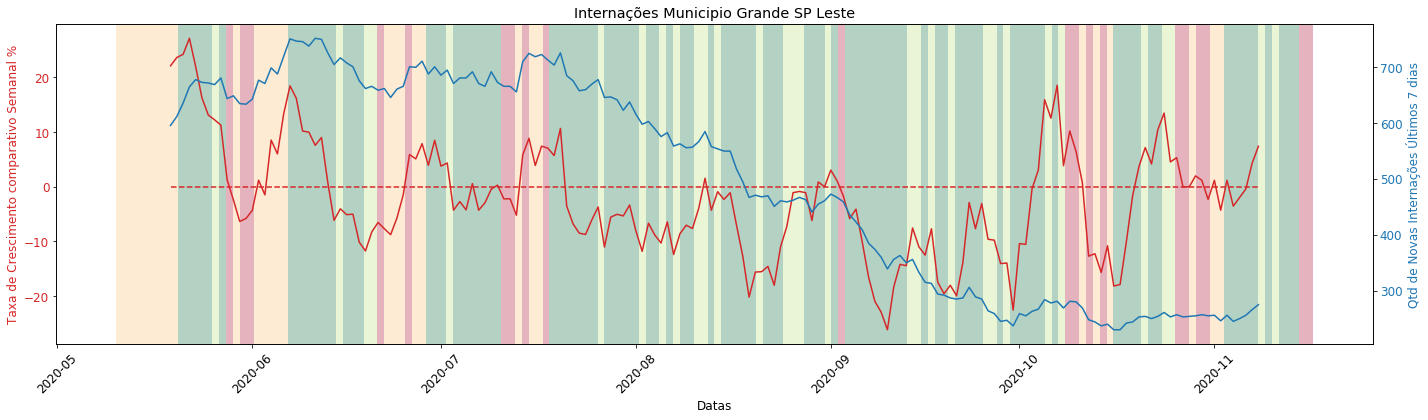

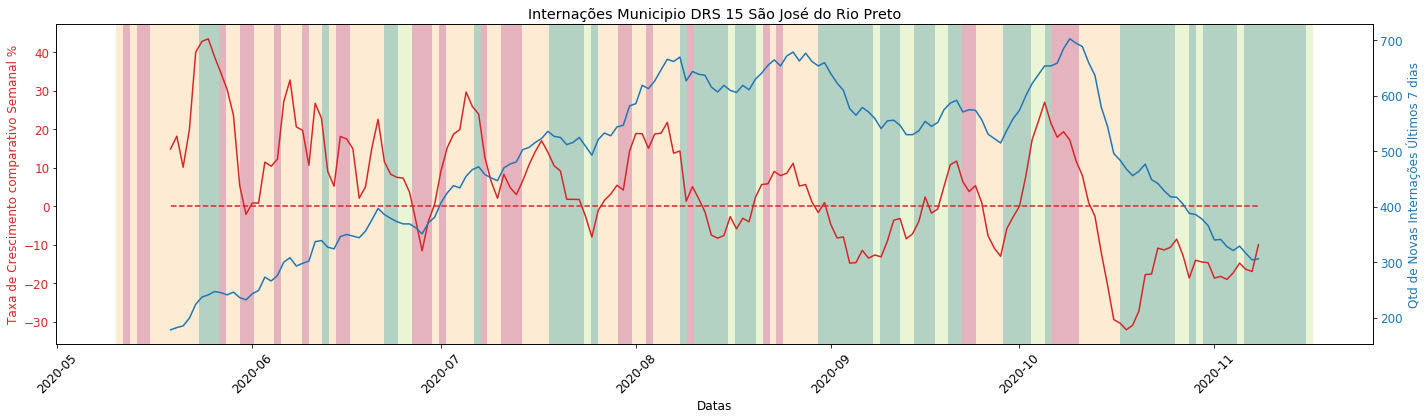

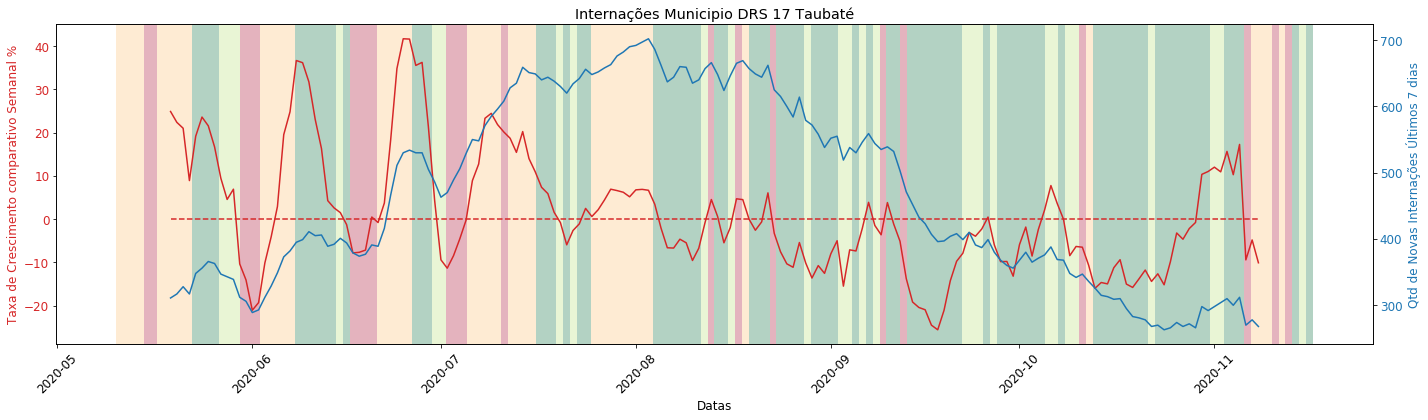

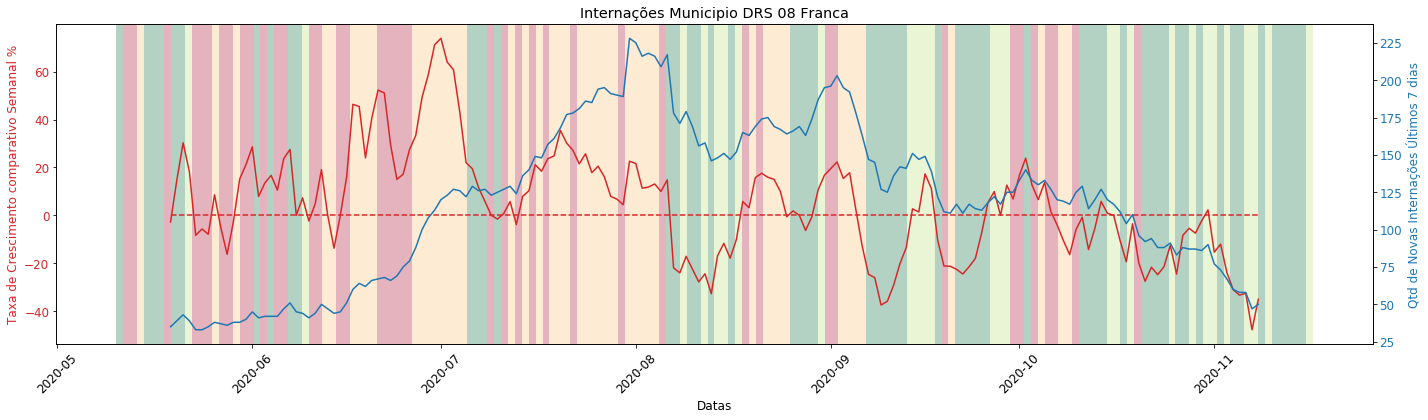

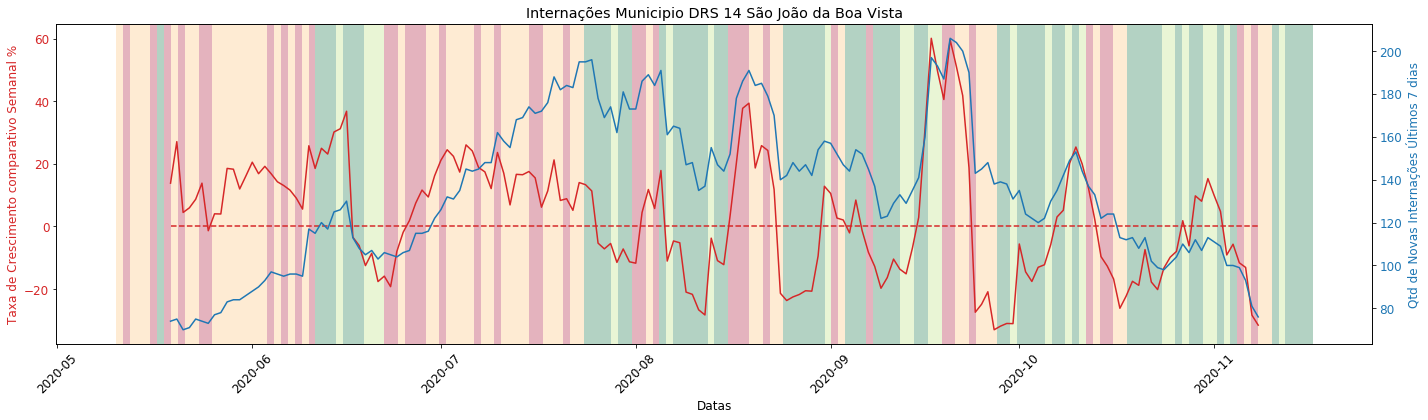

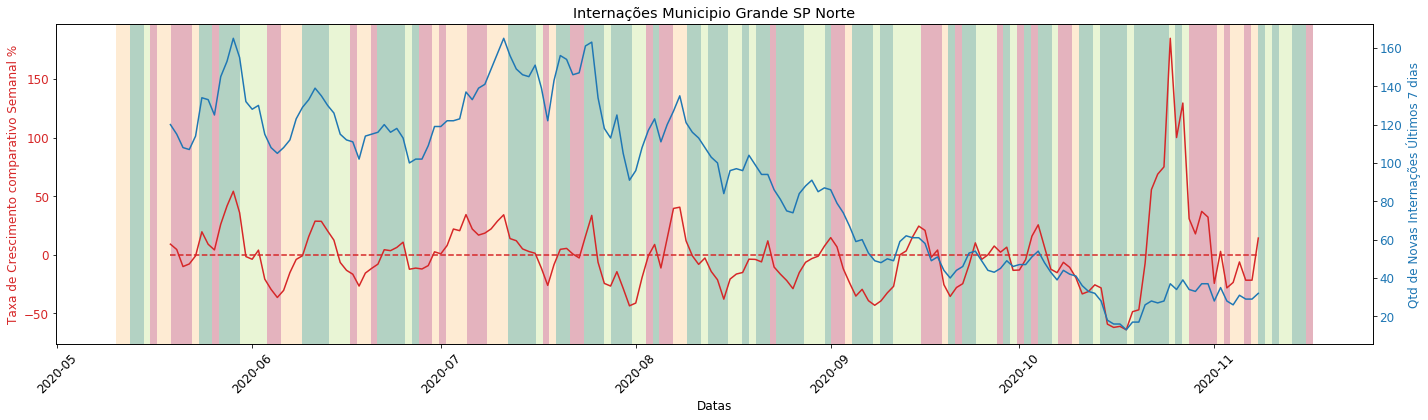

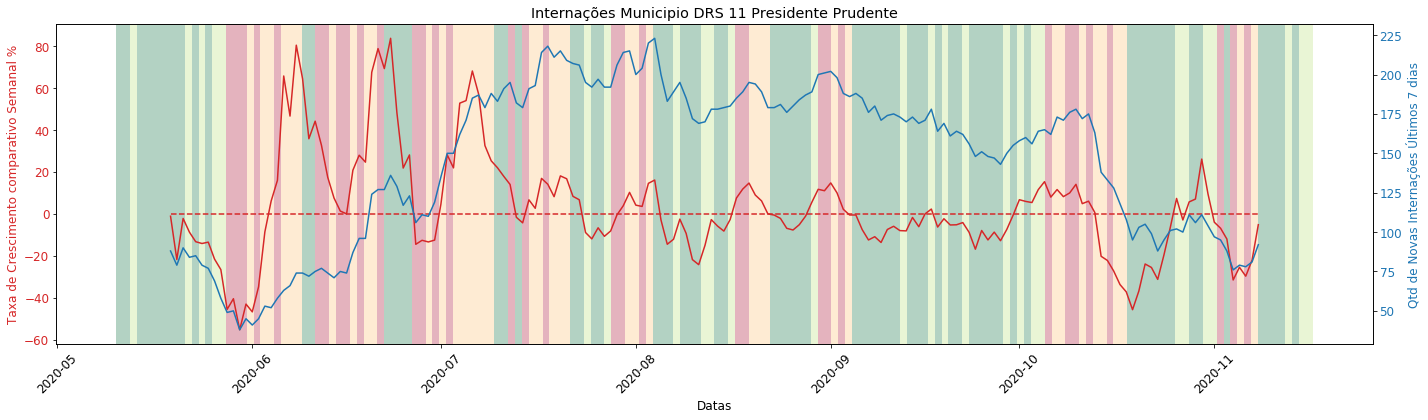

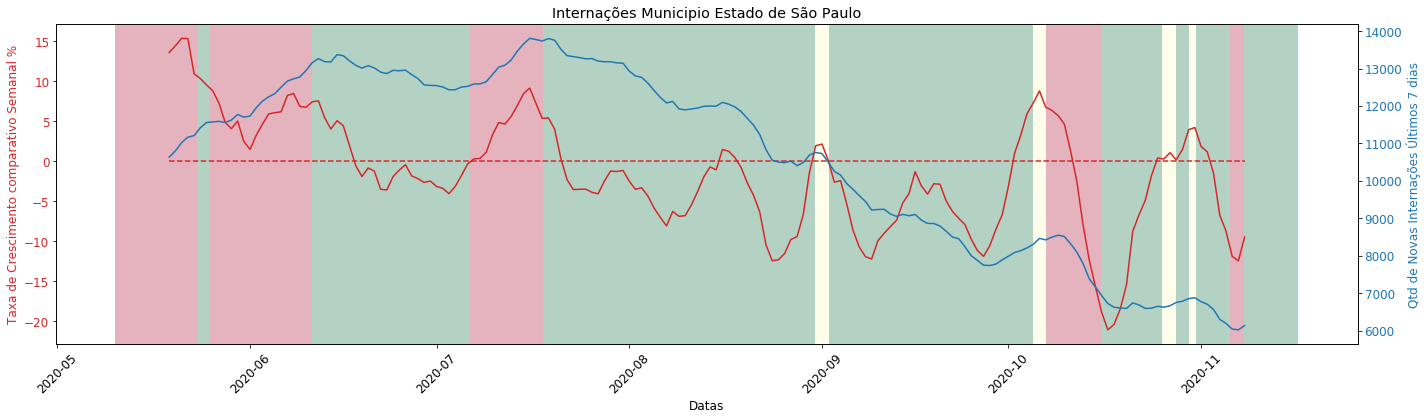

In [93]:
with PdfPages(url_output_pdf_SPReport) as pdf:
    
    generate_report_int_sp(pdf)
        
    d = pdf.infodict()
    d['Title'] = 'Análise de Internações SP - COVID'
    d['Author'] = 'Thiago Villani'
    d['Subject'] = 'Fonte: Repositório de dados sobre casos e óbitos decorrentes do COVID-19 nos municípios do Estado de São Paulo e sobre leitos e internações por Departamento Regional de Saúde'
